# Programming Assignment-2
The goal of this assingment is to allow you to practice several the following things in Python:
1. Perfoming typical data processing (or preprocessing if you prefer). This includes all the typical data wraning such as creating news variables, combining several datasets and more 
2. Running explolatory data analysis including basic plotting of variables 
3. Perfoming basic inferential statisticals using statsmodels and scipy to run hypythesis testing and build simple statistial or econometric models.

## Datasets 
For this assignment, you will use the following datasets:
### Rwanda Health Indicators
The Excel file was generated by combining multiple CSV files, each containing data on different health indicators for Rwanda, So that each sheet in the file represent one such indicator. See below some of the input files which were used:
- `access-to-health-care_subnational_rwa`
- `child-mortality-rates_subnational_rwa`
- `dhs-mobile_subnational_rwa`

You can download the dataset from [here](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true).
### Nights lights Data
- Please download it [here](https://drive.google.com/file/d/1f_4fiqxIejly0YmC088s9bxOfrABv9Sz/view?usp=sharing) and check the documentation in the cells below. 

### Popupation Dataset
- Please download it [here](https://drive.google.com/file/d/1FWEFGdN-xDuFH1jmt0hr4F8Xc3Y5XzvB/view?usp=share_link) and check the documentation and metadata in the class notebooks.


## Submission Guidelines 
- Please guidelines and complete all steps in the [GitHub Workflow](https://dmatekenya.github.io/AIMS-DSCBI/course-requirements/github-workflow.html)
- Once you have completed your assignment, push chanegs to your repository.
- Send a link (copy from within GitHub) to your notebook to the tutors/teaching assistants


# Import Required Packages

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import statsmodels.api as sm
import seaborn as sns

# Setup Input Folders

As usual, it is good practice to set up input folders using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) package. In this section, make sure to define the folders where your data is stored on your machine.

I find it helpful to set up the working directory and input data folders right at the start of the notebook. To keep things organized, I use the naming convention: `FILE_{NAME}` for files and `DIR_{NAME}` for folders. We use capital letters because these are global variables that will be referenced throughout the notebook.

We'll be using the [`pathlib`](https://docs.python.org/3/library/pathlib.html) library, which offers several advantages over traditional string-based path handling:

- **Cross-platform compatibility** - automatically handles path separators (`/` vs `\`) across different operating systems
- **Object-oriented approach** - paths are objects with useful methods rather than strings
- **Intuitive syntax** - use `/` operator to join paths naturally: `parent_dir / "subfolder" / "file.txt"`
- **Built-in path operations** - methods like `.exists()`, `.is_file()`, `.parent`, `.stem`, and `.suffix`
- **Safer path manipulation** - reduces errors from manual string concatenation and splitting

This is the recommended approach for managing file paths in modern Python development.


In [48]:
# Uncomment the following lines and add your code to define the directories and files
DIR_DATA = Path.cwd().parents[1].joinpath("data")
FILE_HEALTH_DATA = DIR_DATA/"RW-Health-Data.xlsx"
FILE_CELL_POP_DATA = DIR_DATA/"rwa-cell-pop.csv"
FILE_CELL_LIGHT_DATA = DIR_DATA/"cell-ntl-2015-2020-2024.csv"

# Part 1: Processing Excel Files
The primary goal is to preprocess an [Excel file](https://docs.google.com/spreadsheets/d/1uvTQYS22VfXXo1Hwkm1frFx_bKkLQkcf/edit?usp=share_link&ouid=113302179168925233984&rtpof=true&sd=true) with multiple sheets into a unified CSV dataset that consolidates multiple indicators. Having all indicators in a single file at the same analytical unit (national, subnational) is more efficient than managing separate files and enables easier cross-indicator analysis.

## Task 1: Generate National-Level Summaries

For each indicator, compute a single national-level value using appropriate aggregation functions such as **mean**, **sum** or **count**. For this one, all available indicators can be summarized at national level, so we will have a CSV file with one row and 

### Expected Output Structure
1. **DataFrame display** in Jupyter Notebook
2. **CSV file** with columns:
- `indicator_name`: Name of the indicator
- `aggregated_value`: Computed national value
- `indicator_year`: Survey year or something similar
- `survey_name`: Name of the survey where information is coming from
- `aggregation_method`: Statistical method used (optional)

## Task 2: Subnational-Level Indicator Dataset

Create a merged dataset for indicators with subnational data (ADM2/ADM3 levels), ensuring spatial alignment and consistent administrative boundaries.

### Expected Output Structure
   - `indicator_name`: Name of the indicator
   - `aggregated_value`: Computed national value
   - `indicator_year`: Survey year or something similar
   - `survey_name`: Name of the survey where information is coming from
   - `aggregation_method`: Statistical method used (optional)

This structure enables both single-indicator and multi-indicator analysis at the subnational level.

In [49]:
sheet_names = pd.ExcelFile(FILE_HEALTH_DATA).sheet_names
excel_file = pd.ExcelFile(FILE_HEALTH_DATA)
combination_of_indicators = pd.concat(
    [excel_file.parse(sheet).iloc[1:] for sheet in sheet_names],
    ignore_index=True
)
population_cell_level = pd.read_csv(FILE_CELL_POP_DATA)
light_cell_level= pd.read_csv(FILE_CELL_LIGHT_DATA)

In [50]:
group_by_indicators = (
    combination_of_indicators
    .groupby(['Indicator', 'SurveyYear', 'SurveyType'])['Value']
    .agg('mean')
    .reset_index()
)
group_by_indicators = group_by_indicators.rename(
    columns={"Indicator": "indicator_name", 
             "SurveyYear": "indicator_year", 
             "SurveyType": "survey_name", 
             "Value": "aggregated_value"})
group_by_indicators["aggregated_value"] = pd.to_numeric(
    group_by_indicators["aggregated_value"], errors="coerce").round(1)


In [51]:
group_by_indicators.to_csv(DIR_DATA / "group_by_indicators.csv", index=False)

group_by_indicators.head(5)

,indicator_name,indicator_year,survey_name,aggregated_value
0,Accepting attitudes towards those living with ...,2005,DHS,48.7
1,Accepting attitudes towards those living with ...,2010,DHS,64.3
2,Accepting attitudes towards those living with ...,2015,DHS,62.8
3,Accepting attitudes towards those living with ...,2005,DHS,47.5
4,Accepting attitudes towards those living with ...,2010,DHS,52.8


In [52]:
pivot_df = group_by_indicators.pivot(
    index=["indicator_name", "survey_name"],  
    columns="indicator_year",                       
    values="aggregated_value"                    
).reset_index()

pivot_df.head(5)

indicator_year,indicator_name,survey_name,1992,2000,2005,2008,2010,2013,2015,2017,2019
0,Accepting attitudes towards those living with ...,DHS,NaN,NaN,48.7,NaN,64.3,NaN,62.8,NaN,NaN
1,Accepting attitudes towards those living with ...,DHS,NaN,NaN,47.5,NaN,52.8,NaN,49.3,NaN,NaN
2,Age specific fertility rate: 15-19,DHS,64.1,50.7,42.0,42.0,41.2,NaN,44.2,NaN,30.0
3,Age specific fertility rate: 15-19,MIS,NaN,NaN,NaN,NaN,NaN,47.2,NaN,40.0,NaN
4,Age specific fertility rate: 20-24,DHS,230.9,239.6,229.4,204.8,184.2,NaN,174.4,NaN,153.2


In [53]:
pivot_df.to_csv(DIR_DATA / "pivot_df.csv", index=False)

In [54]:
#By District and By Province
province_level_indicators = (combination_of_indicators
    .groupby(['Location', 'Indicator', 'SurveyYear', 'SurveyType'])['Value']
    .agg('mean')
    .reset_index()
)

province_level_indicators = province_level_indicators.rename(
    columns={
        "Indicator": "indicator_name",
        "SurveyYear": "indicator_year",
        "SurveyType": "survey_name",
        "Value": "aggregated_value"
    }
)

province_level_indicators.head(10)
#print(province_level_indicators.tail(5))

,Location,indicator_name,indicator_year,survey_name,aggregated_value
0,Butare,Age specific fertility rate: 15-19,1992,DHS,22.0
1,Butare,Age specific fertility rate: 15-19,2000,DHS,18.0
2,Butare,Age specific fertility rate: 20-24,1992,DHS,152.0
3,Butare,Age specific fertility rate: 20-24,2000,DHS,216.0
4,Butare,Age specific fertility rate: 25-29,1992,DHS,243.0
5,Butare,Age specific fertility rate: 25-29,2000,DHS,204.0
6,Butare,Age specific fertility rate: 30-34,1992,DHS,225.0
7,Butare,Age specific fertility rate: 30-34,2000,DHS,238.0
8,Butare,Age specific fertility rate: 35-39,1992,DHS,238.0
9,Butare,Age specific fertility rate: 35-39,2000,DHS,163.0


## Introduction to Nightlights Dataset

## What is Nightlight Data?

Nightlight data is satellite imagery capturing artificial light emissions from Earth's surface during nighttime. Satellites like VIIRS collect this data regularly, providing an **objective, real-time measure of human economic activity and development**.

### Raw Data: Radiance Measurements
The fundamental measurement in nightlight data is **radiance** - the amount of light energy detected by satellite sensors, measured in **nanowatts per square centimeter per steradian (nW/cm²/sr)**. Each pixel in satellite imagery contains a radiance value representing the light intensity from that specific location on Earth's surface.

### Annual Composite Generation
This dataset was created from **annual composite images** using VIIRS nightlight files for Rwanda. Annual composites are generated by:

- **Aggregating daily/monthly observations** throughout each year (2015, 2020, 2024)
- **Filtering out temporary light sources** (fires, lightning, aurora)
- **Removing cloud-affected observations** to ensure clear measurements
- **Averaging or taking median values** to create stable, representative annual measurements
- **Masking techniques** to exclude areas with unreliable data

The files used include both **average composites** (`average_masked`) and **median composites** (`median_masked`), with **cloud-free versions** (`vcmslcfg`) preferred over cloud-inclusive versions (`vcmcfg`) for more accurate measurements.

### Why Use Nightlight Data?

- **Consistent global coverage** - Available everywhere, regardless of local data quality
- **Real-time updates** - More current than traditional economic statistics
- **Objective measurement** - Not subject to reporting biases
- **High resolution** - Captures local development patterns
- **Proxy for development** - Light intensity correlates with economic activity, infrastructure, and quality of life

## Dataset Overview 

- **6,507 observations** across Rwanda's administrative cells
- **Three time periods**: 2015, 2020, 2024
- **Cell-level data** - Rwanda's smallest administrative units
- Allows temporal analysis of development trends

---

## Variable Definitions

### Administrative Identifiers
- **`cell_id`** - Unique identifier for linking with other datasets
- **`province_name`** - Province (5 total in Rwanda)
- **`district_name`** - District (30 total in Rwanda) 
- **`sector_name`** - Administrative level between district and cell
- **`cell_name`** - Specific cell name

### Core Nightlight Measurements

#### `total_nightlight`
- **Sum of all radiance values** within cell boundaries
- **Key indicator** of overall economic activity/development
- Higher values = more total development

#### `mean_nightlight` 
- **Average radiance** per pixel
- Indicates development intensity regardless of cell size
- Useful for comparing cells of different areas

#### `median_nightlight`
- **Middle radiance value** of all pixels (less sensitive to outliers)
- Better represents typical lighting in unevenly developed areas

#### `max_nightlight`
- **Highest radiance** within cell
- Indicates major infrastructure (hospitals, commercial centers)

#### `min_nightlight` & `std_nightlight`
- Minimum radiance and standard deviation
- High std = uneven development within cell

### Spatial Coverage Indicators

#### `pixel_count`
- **Total pixels** in cell (indicates geographic size)
- Used to normalization_function other measurements

#### `lit_pixel_count`
- **Number of pixels with detectable light** (radiance > 0)
- Shows spatial extent of development

#### `lit_pixel_percentage`
- **Percentage of cell area with lighting**
- Formula: `(lit_pixel_count ÷ pixel_count) × 100`
- **0% = completely dark, 100% = fully developed**

#### `year`
- Time period: 2015, 2020, or 2024

# Part-2: Demographic and Nightlights Data

## Part A: Varible Generation and Data Integration

### Population Dataset Variables (`rwa-cell-pop.csv`):
Create the following derived variables:
- **`dependency_ratio`** - `(children_under_five_2020 + elderly_60_plus_2020) / working_age_population * 100`
- **`people_per_building`** - `general_2020 / building_count`
- **`working_age_population`** - `general_2020 - children_under_five_2020 - elderly_60_plus_2020`
- **`infrastructure_index`** - Your own formula that incorporates `people_per_building` and other relevant variables to measure infrastructure adequacy. Document and justify your `infrastructure_index` methodology, explaining how `people_per_building` and other variables contribute to measuring infrastructure pressure.

### Nightlight Dataset Variables (`cell-ntl-2015-2020-2024.csv`):
Create the following temporal and development indicators:
- **`nightlight_change_2015_2024`** - Percentage change in total nightlight from 2015 to 2024
- **`mean_nightlight_change_2015_2024`** - Percentage change in mean nightlight from 2015 to 2024
- **`lit_pixel_percentage`** - Use existing or calculate: `(lit_pixel_count / pixel_count) * 100`

### Data Integration:
Merge the datasets using the appropriate column. 

## Part B: Exploratory Data Analysis

### Correlation Analysis:
1. **Correlation Heatmap**: Create a heatmap showing correlations between 10 key variables (mix of demographic, infrastructure, and nightlight variables). 
2. **Report the top 3 variable pairs** with the highest correlations and interpret their relationships.
3. **Identify unexpected correlations** and discuss potential explanations.

### Nightlight Trend Analysis:
1. **District Ranking**: Report the **top 5 districts** with the highest nightlight growth (2015-2024) and **bottom 5 districts** with the most decline or lowest growth.
2. **Lit Pixel Analysis**: Compare these districts using `lit_pixel_percentage` changes to understand whether growth represents intensification or spatial expansion.
3. **Create visualizations** showing nightlight trends for these extreme districts.

## Part C: Modeling

### Multivariate Linear Regression:
1. **Model Development**: Build a multivariate linear regression model predicting **population density** using both demographic and nightlight variables as predictors. Explore as many variables as possible at the beginning.
2. **Variable Selection**: Test different combinations of variables and report the **top 3 most predictive variables** of population density.
3. **Model Evaluation**: Report R-squared, coefficients, and statistical significance. Interpret what these results tell us about population-infrastructure relationships.



## Notes and Other Requirements
Please follow the genral guidelines below when preparing your analysis..

### Statistical Analysis:
- Properly handle missing data and outliers
- Use appropriate statistical tests and report p-values
- Calculate and interpret correlation coefficients
- Validate regression assumptions (normality, homoscedasticity)

### Data Management:
- Document all data cleaning and aggregation steps using markdown 
- Ensure consistent district naming across datasets

### Visualization Standards:
- Create clear, publication-quality heatmaps with appropriate color scales
- Design effective time series plots for nightlight trends
- Include proper axis labels, titles, and legends
- Use consistent formatting across all visualizations

### Reporting Requirements:
- Clearly state the top 3 most predictive variables with statistical justification
- Provide ranked lists for nightlight growth districts with supporting metrics
- Include model performance statistics and interpretation
- Document all methodological choices and assumptions

In [55]:
population_cell_level['working_age_population'] = (
    population_cell_level['general_2020'] - 
    (population_cell_level['children_under_five_2020'] + population_cell_level['elderly_60_plus_2020'])
)
population_cell_level['dependency_ratio'] = (
    (population_cell_level['children_under_five_2020'] + population_cell_level['elderly_60_plus_2020']) /
    (population_cell_level['working_age_population'])
) * 100


population_cell_level["people_per_building"] = np.where(
    population_cell_level["building_count"] > 0,
    population_cell_level["general_2020"] / population_cell_level["building_count"],
    population_cell_level["general_2020"]  
)


In [56]:
def normalization_function(predictor_column, choice=True):
    normalization_functiond_values = (predictor_column - predictor_column.min()) / (predictor_column.max() - predictor_column.min())
    if choice==True:
        return normalization_functiond_values
    else:
        return 1 - normalization_functiond_values
    

population_cell_level["building_count_norm"] = normalization_function(population_cell_level["building_count"], choice=True)
population_cell_level["people_per_building_norm"] = normalization_function(population_cell_level["people_per_building"], choice=False)
population_cell_level["dependency_ratio_norm"] = normalization_function(population_cell_level["dependency_ratio"], choice=False)

population_cell_level["infrastructure_index"] = (
    0.5* population_cell_level["building_count_norm"] +
    0.2 * population_cell_level["people_per_building_norm"] +
    0.3 * population_cell_level["dependency_ratio_norm"]
)*100

population_cell_level = population_cell_level.drop(columns=['building_count_norm', 'people_per_building_norm', 'dependency_ratio_norm'])


In [57]:

filtaring_2015_2024 = light_cell_level[light_cell_level['year'].isin([2015, 2024])]

pivoting = filtaring_2015_2024.pivot(
    index=["cell_id", "cell_name", "dist_name", "lit_pixel_percentage"], 
    columns="year",
    values=["total_nightlight", "mean_nightlight"]
).reset_index()


pivoting.columns = [
    f"{col[0]}_{col[1]}" if col[1] != '' else col[0]
    for col in pivoting.columns.to_flat_index()
]

pivoting['nightlight_change_2015_2024'] = ( (pivoting['total_nightlight_2024'] - pivoting['total_nightlight_2015']) / pivoting['total_nightlight_2015']) * 100
pivoting['mean_nightlight_change_2015_2024'] = ( (pivoting['mean_nightlight_2024'] - pivoting['mean_nightlight_2015']) / pivoting['mean_nightlight_2015']) * 100

pivoting.head()

,cell_id,cell_name,dist_name,lit_pixel_percentage,total_nightlight_2015,total_nightlight_2024,mean_nightlight_2015,mean_nightlight_2024,nightlight_change_2015_2024,mean_nightlight_change_2015_2024
0,RWA.1.1.1.1_1,Bungwe,Burera,37.142857,1.900350,11.608531,0.027148,0.165836,510.862720,510.862733
1,RWA.1.1.1.2_1,Bushenya,Burera,42.857143,1.536613,10.771848,0.024391,0.170982,601.012355,601.012330
2,RWA.1.1.1.3_1,Mudugari,Burera,43.333333,1.445172,10.102386,0.024086,0.168373,599.043610,599.043614
3,RWA.1.1.1.4_1,Tumba,Burera,43.434343,2.817203,17.876629,0.028457,0.180572,534.552323,534.552310
4,RWA.1.1.10.1_1,Bugamba,Burera,46.000000,3.146631,20.117586,0.031466,0.201176,539.337363,539.337358


In [58]:
combination_of_light = pd.merge(population_cell_level, light_cell_level, on='cell_id', how='outer')

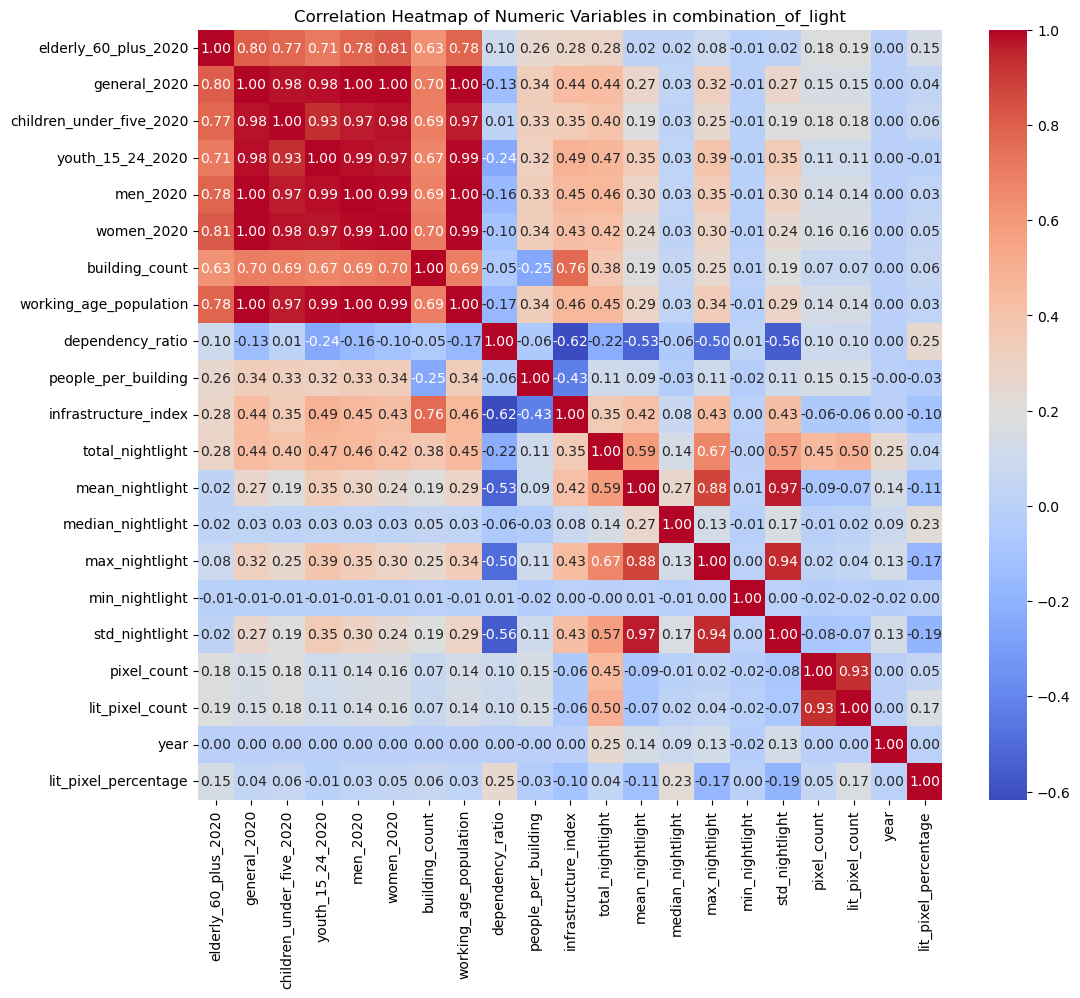

In [59]:

columns_in_numbers = combination_of_light.select_dtypes(include=[np.number]).columns
correlation_matrix = combination_of_light[columns_in_numbers].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Variables in combination_of_light")
plt.show()

In [60]:
relevant_variables = ['general_2020', 
                      'building_count', 
                      'working_age_population', 
                      'dependency_ratio', 
                      'people_per_building', 
                      'infrastructure_index', 
                      'total_nightlight', 
                      'mean_nightlight', 
                      'lit_pixel_count',
                      'lit_pixel_percentage']

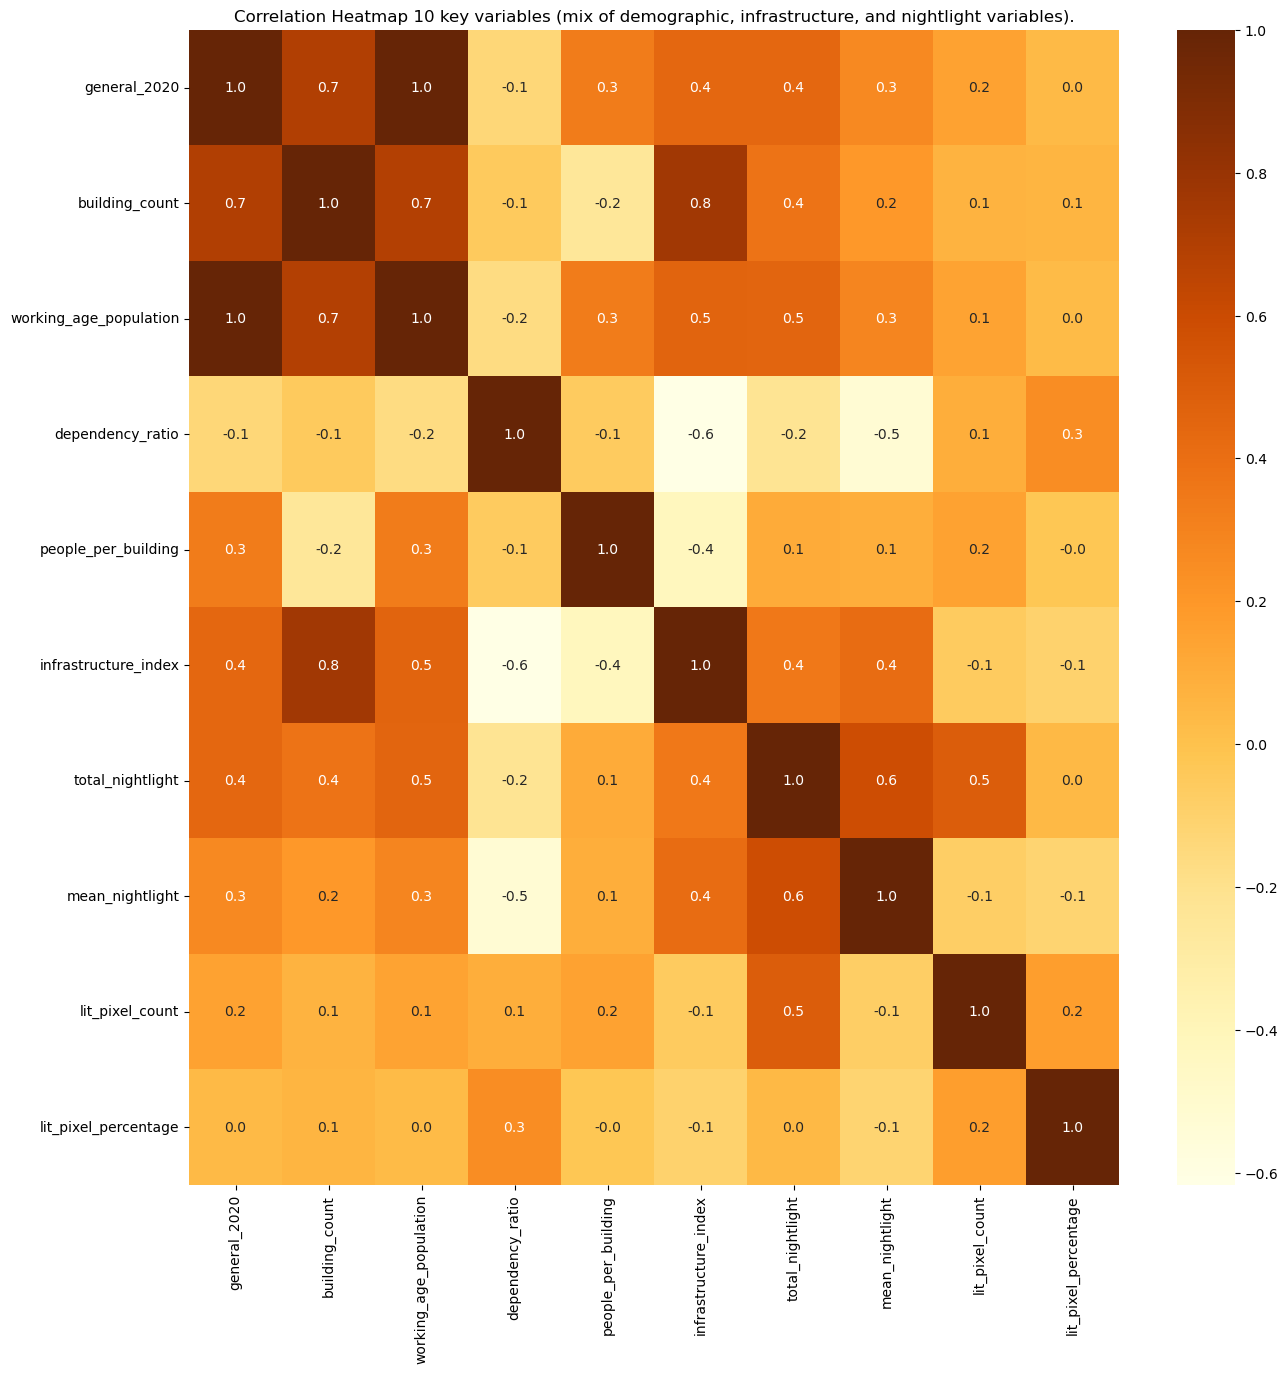

In [61]:

# Correlation matrix for relevant variables
correlation_matrix = combination_of_light[relevant_variables].corr()

# Plot heatmap
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='YlOrBr', fmt=".1f")
plt.title("Correlation Heatmap 10 key variables (mix of demographic, infrastructure, and nightlight variables).")
plt.show()

### Analysis of Correlated Variables

The top three variable pairs show strong, logical connections. The *general population* and *working-age population* are highly correlated, which is expected since the latter is a part of the former. A negative correlation exists between *people per building* and the *infrastructure index, suggesting that overcrowded areas often have less developed infrastructure. Conversely, the **infrastructure index* and *building count* are positively correlated, indicating that areas with more buildings tend to have better infrastructure.

### Unexpected Correlations

Two surprising relationships were also found. There's a link between *light-related variables* and *demographic variables, likely because more populated areas need more lighting. Additionally, a high **dependency ratio* is associated with lower *mean light intensity*, which could mean areas with a larger proportion of non-working individuals use less electricity or have less infrastructure.

In [62]:

needed_variables = ['lit_pixel_percentage','nightlight_change_2015_2024', 'mean_nightlight_change_2015_2024']
district_averages = pivoting.groupby('dist_name')[needed_variables].mean().round(1).reset_index()

district_averages.head()

,dist_name,lit_pixel_percentage,nightlight_change_2015_2024,mean_nightlight_change_2015_2024
0,Bugesera,43.9,716.3,716.3
1,Burera,42.4,561.9,561.9
2,Gakenke,41.5,447.2,447.2
3,Gasabo,38.5,410.9,410.9
4,Gatsibo,42.0,580.3,580.3


In [63]:
district_averages_sorted = district_averages.sort_values('nightlight_change_2015_2024', ascending=False)

top_5_districts_growth = district_averages_sorted.head(5)
print("Top 5 districts with highest nightlight growth (2015-2024):")
print(top_5_districts_growth[['dist_name', 'nightlight_change_2015_2024', 'lit_pixel_percentage']])

bottom_5_districts_growth = district_averages_sorted.tail(5)
print("\n\nBottom 5 districts with lowest nightlight growth (2015-2024):")
print(bottom_5_districts_growth[['dist_name', 'nightlight_change_2015_2024', 'lit_pixel_percentage']])

Top 5 districts with highest nightlight growth (2015-2024):
    dist_name  nightlight_change_2015_2024  lit_pixel_percentage
23  Nyaruguru                        733.6                  44.5
18  Nyagatare                        730.3                  43.0
0    Bugesera                        716.3                  43.9
12     Kirehe                        633.3                  44.0
15      Ngoma                        616.3                  43.0


Bottom 5 districts with lowest nightlight growth (2015-2024):
     dist_name  nightlight_change_2015_2024  lit_pixel_percentage
21      Nyanza                        399.0                  44.5
13     Muhanga                        390.8                  43.7
11    Kicukiro                        387.8                  34.2
24      Rubavu                        318.4                  38.5
22  Nyarugenge                        192.7                  28.9


In [64]:
district_averages_sorted = district_averages.sort_values('lit_pixel_percentage', ascending=False)

top_5_districts_light = district_averages_sorted.head(5)
print("Top 5 districts with highest lit pixel percentages:")
print(top_5_districts_light[['dist_name', 'nightlight_change_2015_2024', 'lit_pixel_percentage']])

bottom_5_districts_light = district_averages_sorted.tail(5)
print("\n\nBottom 5 districts with lowest lit pixel percentages:")
print(bottom_5_districts_light[['dist_name', 'nightlight_change_2015_2024', 'lit_pixel_percentage']])

Top 5 districts with highest lit pixel percentages:
    dist_name  nightlight_change_2015_2024  lit_pixel_percentage
8     Kamonyi                        453.6                  44.8
10    Kayonza                        434.7                  44.7
23  Nyaruguru                        733.6                  44.5
21     Nyanza                        399.0                  44.5
6    Gisagara                        539.8                  44.2


Bottom 5 districts with lowest lit pixel percentages:
     dist_name  nightlight_change_2015_2024  lit_pixel_percentage
14     Musanze                        539.5                  38.5
5      Gicumbi                        568.7                  38.2
27      Rusizi                        491.3                  38.2
11    Kicukiro                        387.8                  34.2
22  Nyarugenge                        192.7                  28.9


### Comparison of Nightlight Growth and Coverage

Districts such as Nyaruguru, Nyagatare, and Bugesera demonstrate the highest nightlight growth, largely through intensification in areas that are already moderately well-lit (~43–45% coverage).
By contrast, Nyarugenge, Kicukiro, and Rubavu show both lower growth and lower coverage, indicating slower intensification and a more concentrated pattern of lighting within specific urban centers rather than across the wider district.

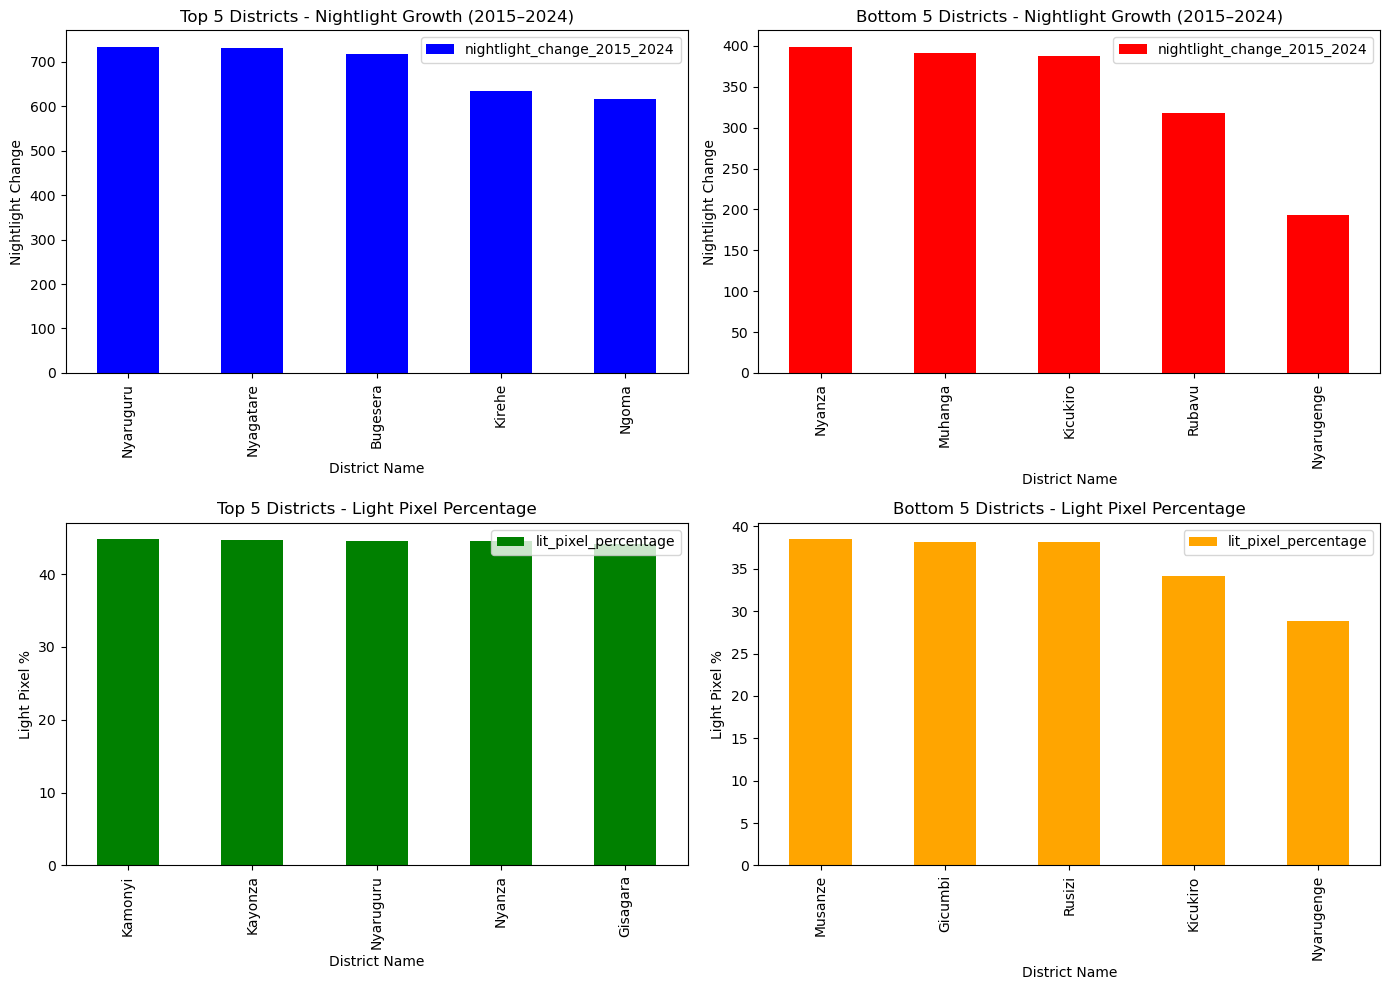

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(14,10))

top_5_districts_growth.plot(x="dist_name", y="nightlight_change_2015_2024", kind="bar",
                ax=axes[0,0], color="blue")
axes[0,0].set_title("Top 5 Districts - Nightlight Growth (2015–2024)")
axes[0,0].set_xlabel("District Name")
axes[0,0].set_ylabel("Nightlight Change")

bottom_5_districts_growth.plot(x="dist_name", y="nightlight_change_2015_2024", kind="bar",
                   ax=axes[0,1], color="red")
axes[0,1].set_title("Bottom 5 Districts - Nightlight Growth (2015–2024)")
axes[0,1].set_xlabel("District Name")
axes[0,1].set_ylabel("Nightlight Change")

top_5_districts_light.plot(x="dist_name", y="lit_pixel_percentage", kind="bar",
             ax=axes[1,0], color="green")
axes[1,0].set_title("Top 5 Districts - Light Pixel Percentage")
axes[1,0].set_xlabel("District Name")
axes[1,0].set_ylabel("Light Pixel %")

bottom_5_districts_light.plot(x="dist_name", y="lit_pixel_percentage", kind="bar",
                ax=axes[1,1], color="orange")
axes[1,1].set_title("Bottom 5 Districts - Light Pixel Percentage")
axes[1,1].set_xlabel("District Name")
axes[1,1].set_ylabel("Light Pixel %")

plt.tight_layout()
plt.show()

In [66]:
"""
According to the documentation, the Nightlights Dataset is derived from the VIIRS satellite. 
Based on supporting research, each pixel approximately represents 0.215 km². 
Therefore, the area of a cell can be estimated as:
    cell_area_km2 = pixel_count * 0.215

Using this, population density can be approximated as:
    population_density = general_2020 / (pixel_count * 0.215)
"""


area_per_pixel = 0.215 

combination_of_light["cell_area_km2"] = combination_of_light["pixel_count"] * area_per_pixel
combination_of_light["population_density"] = (
    combination_of_light["general_2020"] / combination_of_light["cell_area_km2"]
)

# combination_of_light.head()

In [67]:
"""
Selecting the predictors start with removing the variable used to calculate the population density (general_2020 and cell_area_km2). 
"""

predictors = [
    'elderly_60_plus_2020', 'children_under_five_2020',
    'youth_15_24_2020', 'men_2020', 'women_2020', 'building_count',
    'working_age_population', 'dependency_ratio', 'people_per_building',
    'infrastructure_index', 'total_nightlight', 'mean_nightlight', 
    'median_nightlight', 'max_nightlight', 'min_nightlight', 'std_nightlight',
    'pixel_count', 'lit_pixel_count', 'lit_pixel_percentage'
]

X = combination_of_light[predictors]
y = combination_of_light['population_density']

X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     population_density   R-squared:                       0.688
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     795.9
Date:                Wed, 20 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:39:03   Log-Likelihood:                -46159.
No. Observations:                6507   AIC:                         9.236e+04
Df Residuals:                    6488   BIC:                         9.248e+04
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                   

In [68]:
results_df = pd.DataFrame({
    'Variable': model.params.index,
    'Coefficient': model.params.values,
    'p_value': model.pvalues.values
})

results_df = results_df[results_df['Variable'] != 'const']

# Top 3 by statistical significance (Smaller p-value means that the predictor affects the population density.)
top3_signif = results_df.sort_values(by='p_value').head(3)
print("\nTop 3 predictors by significance (lowest p-values):")
print(top3_signif)



Top 3 predictors by significance (lowest p-values):
               Variable  Coefficient        p_value
11     total_nightlight    -3.538929  1.305363e-115
9   people_per_building    41.467672   1.806813e-54
3      youth_15_24_2020     0.633445   2.219208e-46


In [69]:
"""
Testing the model with the top 3 predictors.
"""

predictors = ['total_nightlight', 'people_per_building', 'youth_15_24_2020']

X = combination_of_light[predictors]
y = combination_of_light['population_density']

X_with_const = sm.add_constant(X)

model = sm.OLS(y, X_with_const).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:     population_density   R-squared:                       0.343
Model:                            OLS   Adj. R-squared:                  0.343
Method:                 Least Squares   F-statistic:                     1134.
Date:                Wed, 20 Aug 2025   Prob (F-statistic):               0.00
Time:                        23:39:03   Log-Likelihood:                -48582.
No. Observations:                6507   AIC:                         9.717e+04
Df Residuals:                    6503   BIC:                         9.720e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -109.6117    